Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating image for caption: 'a golden retriever standing in the snow'...


  0%|          | 0/50 [00:00<?, ?it/s]

Raw similarity scores: [0.8340084 0.6691819 0.7436898 0.5637197]


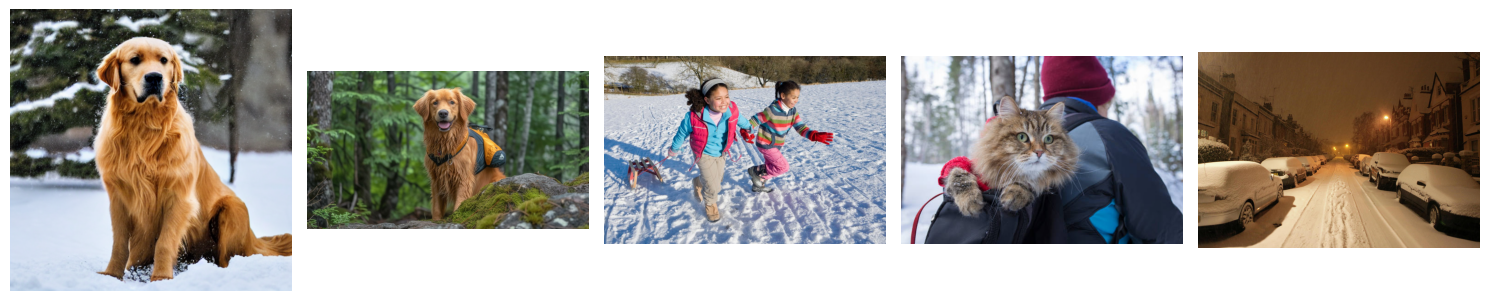

Similarity Analysis Results:
Reference: Generated image for 'a golden retriever standing in the snow'
Image 1 (hiking-golden-r...): 0.834
Image 2 (shutterstock_12...): 0.669
Image 3 (hiking-with-cat...): 0.744
Image 4 (snowy-street-at...): 0.564

Highest similarity: Image 1 with score 0.834


In [3]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 2. Load the Stable Diffusion model for image generation
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda" if torch.cuda.is_available() else "cpu")

# 3. Define the caption
caption = "a golden retriever standing in the snow"

# 4. Generate the image for the caption
print("Generating image for caption: 'a golden retriever standing in the snow'...")
generated_image = pipe(caption, num_inference_steps=50).images[0]

# 5. Preprocess new set of images to compare against
image_urls = [
    "https://images.stockcake.com/public/5/3/d/53d66a85-7114-44b5-b750-d323f7ab70f6/hiking-golden-retriever-stockcake.jpg",  # Golden retriever in a forest
    "https://storage.googleapis.com/treatspace-prod-media/pracimg/u-564/shutterstock_1297788745.jpeg",  # kids in a snow
    "https://media.istockphoto.com/id/1132095084/photo/hiking-with-cat-in-winter.jpg?s=612x612&w=0&k=20&c=aXFXNPm_YaUZdxxS3j8Uza3Twb7E2QS7UWeCh0X9Xb0=",  # Cat in a snowy forest with a person
    "https://images.fineartamerica.com/images/artworkimages/mediumlarge/2/snowy-street-at-night-richard-newstead.jpg"   # City street at night with no dog or snow
]

images = []
headers = {'User-Agent': 'Mozilla/5.0'}  # Add user agent to avoid blocking
for url in image_urls:
    try:
        response = requests.get(url, stream=True, timeout=5, headers=headers)
        response.raise_for_status()  # Check for HTTP errors
        img = Image.open(response.raw).convert('RGB')
        images.append(img)
    except Exception as e:
        print(f"Failed to load image from {url}: {str(e)}")
        images.append(None)

# Check if we have any valid images
if not any(images):
    raise ValueError("No images could be loaded successfully. Please check the URLs or your internet connection.")

# 6. Extract & Normalize embeddings
def get_embeddings(generated_image, images):
    # Process the generated image
    generated_inputs = processor(images=[generated_image], return_tensors="pt", padding=True)

    # Process the comparison images (only valid ones)
    valid_images = [img for img in images if img is not None]
    if not valid_images:
        raise ValueError("No valid images to process")

    image_inputs = processor(images=valid_images, return_tensors="pt", padding=True)

    # Get embeddings
    with torch.no_grad():
        generated_embedding = model.get_image_features(**generated_inputs)
        image_embeddings = model.get_image_features(**image_inputs)

    # Normalize embeddings
    generated_embedding = generated_embedding / generated_embedding.norm(dim=-1, keepdim=True)
    image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return generated_embedding, image_embeddings

# 7. Compare the generated image with the other images
try:
    generated_emb, image_emb = get_embeddings(generated_image, images)

    # 8. Compute similarity scores
    similarity_scores = (generated_emb @ image_emb.T).squeeze(0)
    scores = similarity_scores.cpu().numpy()

    # Debug: Print raw scores
    print("Raw similarity scores:", scores)

    # 9. Visualize the results
    plt.figure(figsize=(15, 10))

    # Display the generated image
    plt.subplot(2, sum(x is not None for x in images) + 1, 1)
    plt.imshow(generated_image)
    plt.axis('off')

    # Display the comparison images
    valid_idx = 0
    for i, (img, url) in enumerate(zip(images, image_urls)):
        if img is not None:
            plt.subplot(2, sum(x is not None for x in images) + 1, valid_idx + 2)
            plt.imshow(img)
            plt.axis('off')
            valid_idx += 1

    plt.tight_layout()
    plt.show()

    # 10. Document findings
    print("Similarity Analysis Results:")
    print(f"Reference: Generated image for '{caption}'")
    valid_images_indices = [i for i, img in enumerate(images) if img is not None]
    valid_idx = 0
    for i, url in enumerate(image_urls):
        if images[i] is not None:
            print(f"Image {i+1} ({url.split('/')[-1][:15]}...): {scores[valid_idx]:.3f}")
            valid_idx += 1

    # Additional analysis with correct indexing
    if scores.size > 0:
        max_score_idx = np.argmax(scores)
        actual_image_idx = valid_images_indices[max_score_idx] + 1
        print(f"\nHighest similarity: Image {actual_image_idx} with score {scores[max_score_idx]:.3f}")

except Exception as e:
    print(f"Error processing embeddings or visualization: {str(e)}")